In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('bmh')

In [2]:
import numpy as np
import attr
import ujson
import torch

from itertools import islice
from tqdm import tqdm_notebook
from glob import glob
from collections import Counter

from gensim.models import KeyedVectors

from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
vectors = KeyedVectors.load_word2vec_format(
    '../data/vectors/GoogleNews-vectors-negative300.bin.gz',
    binary=True,
)

In [4]:
class Corpus:
    
    def __init__(self, pattern, skim=None):
        self.pattern = pattern
        self.skim = skim
        
    def lines(self):
        for path in glob(self.pattern):
            with open(path) as fh:
                for line in fh:
                    yield line.strip()

    def abstracts(self):
        lines = self.lines()
        if self.skim:
            lines = islice(lines, self.skim)
        for line in tqdm_notebook(lines, total=self.skim):
            raw = ujson.loads(line)
            yield Abstract.from_raw(raw)
            
    def xy(self):
        for abstract in self.abstracts():
            yield from abstract.xy()

In [5]:
@attr.s
class Abstract:
    
    sentences = attr.ib()
    
    @classmethod
    def from_raw(cls, raw):
        return cls([Sentence(s['token']) for s in raw['sentences']])
            
    def xy(self):
        for i, sent in enumerate(self.sentences):
            try:
                x = sent.tensor()
                y = i / (len(self.sentences)-1)
                y = torch.FloatTensor([y])
                yield x, y
            except RuntimeError as e:
                pass

In [6]:
@attr.s
class Sentence:
    
    tokens = attr.ib()
    
    def tensor(self, dim=300, pad=50):
        x = [vectors[t] for t in self.tokens if t in vectors]
        x += [np.zeros(dim)] * pad
        x = x[:pad]
        x = np.array(x)
        x = torch.from_numpy(x)
        x = x.float()
        return x

In [7]:
class Model(nn.Module):
    
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(embed_dim, hidden_dim, nonlinearity='relu', batch_first=True)
        self.hidden2y = nn.Linear(hidden_dim, 1)
        
    def init_hidden(self):
        self.hidden = Variable(torch.zeros(1, 1, self.hidden_dim))
        
    def forward(self, x):
        rnn_out, self.hidden = self.rnn(x, self.hidden)
        y = self.hidden2y(self.hidden)
        return y

In [8]:
train = Corpus('../data/train.json/*.json', 100000)

In [9]:
train_xy = list(train.xy())

HBox(children=(IntProgress(value=0, max=100000), HTML(value='')))

In [10]:
loader = DataLoader(train_xy, 32)

In [11]:
torch.manual_seed(1)

In [12]:
embed_dim = train_xy[0][0].shape[1]

In [13]:
model = Model(embed_dim, 150)

In [14]:
criterion = nn.MSELoss()

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [16]:
train_loss = []
for epoch in range(20):
    
    print(f'Epoch {epoch}')
    
    epoch_loss = 0
    for x, y in tqdm_notebook(loader):

        x = Variable(x)
        y = Variable(y)

        model.zero_grad()
        model.init_hidden()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        loss.backward()

        optimizer.step()
        
        epoch_loss += loss.data[0]
        
    epoch_loss /= len(loader)
    train_loss.append(epoch_loss)
    print(epoch_loss)

Epoch 0


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.0977231042984997
Epoch 1


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.08312114731883546
Epoch 2


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.08036533749595433
Epoch 3


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07907533832836751
Epoch 4


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07803355442963926
Epoch 5


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.0773321765318489
Epoch 6


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07764848315146297
Epoch 7


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.0765960684549366
Epoch 8


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07659503769331955
Epoch 9


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07534102981052124
Epoch 10


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07824398326890897
Epoch 11


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07954446600384123
Epoch 12


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07928912250108786
Epoch 13


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.11021024542739012
Epoch 14


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.10005530857428235
Epoch 15


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07722132984429295
Epoch 16


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07442849558519736
Epoch 17


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.0732699196559967
Epoch 18


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07285486690779433
Epoch 19


HBox(children=(IntProgress(value=0, max=16801), HTML(value='')))


0.07217221719356234


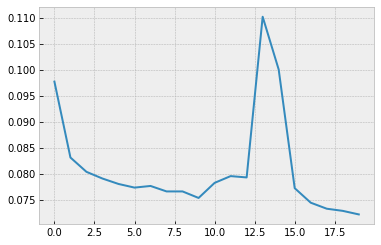

In [17]:
plt.plot(train_loss)

In [19]:
dev = Corpus('../data/dev.json/*.json', 10000)

In [20]:
correct = Counter()
total = Counter()

for ab in dev.abstracts():
    
    x, _ = zip(*ab.xy())

    x = torch.stack(x)
    x = Variable(x)
    
    model.init_hidden()

    y = model(x)
    
    y = np.array(y.data[0].tolist())[:,0]
    order = list(y.argsort().argsort())
    
    if sorted(order) == order:
        correct[len(order)] += 1
        
    total[len(order)] += 1

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [21]:
for slen in sorted(correct.keys()):
    print(slen, correct[slen] / total[slen])

2 0.8929384965831435
3 0.6153366583541147
4 0.3006034009873834
5 0.13175470552519733
6 0.049003322259136214
7 0.006329113924050633
8 0.005979073243647235


In [22]:
sum(correct.values()) / sum(total.values())

0.2605

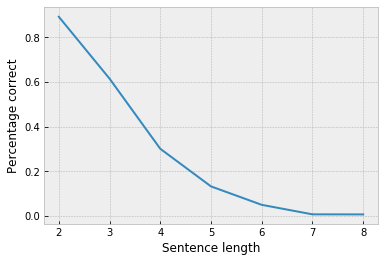

In [23]:
x = sorted(correct.keys())
y = [correct[slen] / total[slen] for slen in x]

plt.xlabel('Sentence length')
plt.ylabel('Percentage correct')     
plt.plot(x, y)